In [12]:
import math
import nltk
import pandas as pd
import numpy as np
import re

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier

from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# https://towardsdatascience.com/text-analysis-feature-engineering-with-nlp-502d6ea9225d

analyser = SentimentIntensityAnalyzer()
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\jexia\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [13]:
# train = pd.read_csv('/Users/mtjen/Desktop/313/project/train.csv')
train = pd.read_csv('train.csv')
train

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


Not disaster: 57.03402075397347%
Is disaster: 42.96597924602653%


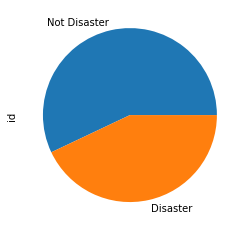

In [14]:
# Data Exploration
targets = train.groupby('target').count()['id']
ratio = targets/(targets.sum())
targets.plot(kind='pie', labels=['Not Disaster', 'Disaster'])
print(f"Not disaster: {ratio[0]*100}%")
print(f"Is disaster: {ratio[1]*100}%")
# So, we don't have to worry about data imbalance

In [15]:
# Check for missing and duplicate data
print("MISSING:")
print(train.isnull().sum())

print("\nDUPLICATE:")
print(train.duplicated().sum())

MISSING:
id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

DUPLICATE:
0


In [16]:
# clean tweets    
def clean(text):
    # remove non-printable characters
    cleaned = ''.join([word for word in text if word.isprintable()])
    
    # remove character references
    cleaned = re.sub(r'&[a-zA-Z]+;?', '', cleaned)
    
    return cleaned


train['text'] = train['text'].apply(clean)


cleanedTweets = []

for index in range(len(train)):
    tweet = train['text'][index]
    cleaned = re.sub(r'[^\w\s]', '', str(tweet).lower().strip())
    cleanedTweets.append(cleaned)
    
train['cleanedTweets'] = cleanedTweets

# textblob sentiment
train["sentimentText"] = train['cleanedTweets'].apply(lambda x: 
                                                      TextBlob(x).sentiment.polarity)

# vader sentiment
train["sentimentVader"] = train['cleanedTweets'].apply(lambda x: 
                                                       analyser.polarity_scores(x)['compound'])

# move target to end
col = train.pop('target')
train.insert(len(train.columns), 'target', col)

train

,id,keyword,location,text,cleanedTweets,sentimentText,sentimentVader,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,our deeds are the reason of this earthquake ma...,0.000000,0.2732,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,forest fire near la ronge sask canada,0.100000,-0.3400,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,all residents asked to shelter in place are be...,-0.018750,-0.2960,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",13000 people receive wildfires evacuation orde...,0.000000,0.0000,1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,just got sent this photo from ruby alaska as s...,0.000000,0.0000,1
...,...,...,...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,two giant cranes holding a bridge collapse int...,0.000000,-0.4939,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,aria_ahrary thetawniest the out of control wil...,0.150000,-0.5849,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,m194 0104 utc5km s of volcano hawaii httptcozd...,0.000000,0.0000,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,police investigating after an ebike collided w...,-0.260417,-0.7845,1


In [17]:
##### added proper noun

charsToCheck = {'!', '@', '#', '?', '.', ',', 'http'}
vowels = {'a', 'e', 'i', 'o', 'u', 'A', 'E', 'I', 'O', 'U'}
nouns = {'NN', 'NNS', 'NNP', 'NNPS'}
verbs = {'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ'}
adj = {'JJ', 'JJR', 'JJS'}
adv = {'RR', 'RBR', 'RBS'}

hasLocation = []
hasKeyword = []
tweetNumberOfChars = []
specialCharacters = []
numberOfWords = []
avgCharsPerWord = []
numNumericTweet = []
numLettersTweet = []
numUpperTweet = []
numVowelsTweet = []
numConsonantsTweet = []
numNouns = []
numVerbs = []
numPrep = []
numAdj = []
numAdv = []
charsPerSentenceTweet = []
numSentencesTweet = []
numProperNoun = []


for index in range(len(train)):
    ##### location
    location = 0
    if pd.isnull(train['location'][index]) == False:
            location = 1
            
    ##### keyword
    keyword = 0
    if pd.isnull(train['keyword'][index]) == False:
            keyword = 1
    
    ###### tweet
    text = train['text'][index]
    # number of characters in tweets
    numCharsTweet = len(text)
    
    # average number of characters in sentence
    sentences = text.split('.')
    charsPerSentence = []
    for sentence in sentences:
        numCharsSentence = len(sentence)
        charsPerSentence.append(numCharsSentence)
    avgCharsPerSentence = np.mean(charsPerSentence)
    
    # number of specific special characters in tweet
    specialChars = []
    for specialChar in charsToCheck:
        numSpecialChar = text.count(specialChar)
        specialChars.append(numSpecialChar)
    
    # average characters per word
    words = text.split()
    lenWords = []
    numNumeric = 0
    numLetters = 0
    numUpper = 0
    numVowels = 0
    numConsonants = 0
    
    nounNum = 0
    verbNum = 0
    prepNum = 0
    adjNum = 0
    advNum = 0
    properNounNum = 0
    
    ans = nltk.pos_tag(words)
    for pair in ans:
        wordType = pair[1]
        if (wordType == 'NNP') or (wordType == 'NNPS'):
            properNounNum += 1
        elif wordType in nouns:
            nounNum += 1
        elif wordType in verbs:
            verbNum += 1
        elif wordType == 'IN':
            prepNum += 1
        elif wordType in adj:
            adjNum += 1
        elif wordType in adv:
            advNum += 1
    
    for word in words:
        wordLength = len(word)
        lenWords.append(wordLength)
        
        # number of letters/numbers, uppercase, vowels, consonants
        for char in word:
            if char.isnumeric():
                numNumeric += 1
            if char.isalpha():
                numLetters += 1
                if char.isupper():
                    numUpper += 1
                if char in vowels:
                    numVowels += 1
                else:
                    numConsonants += 1
        
    wordLengthAvg = np.mean(lenWords)
    
    # tweets with 1 word
    if math.isnan(wordLengthAvg):
        wordLengthAvg = 1
    
    # number of words and sentences
    numWords = len(words)
    numSentences = len(sentences)
    
    hasLocation.append(location)
    hasKeyword.append(keyword)
    tweetNumberOfChars.append(numCharsTweet)
    specialCharacters.append(specialChars)
    numberOfWords.append(numWords)
    avgCharsPerWord.append(wordLengthAvg)
    numNumericTweet.append(numNumeric)
    numLettersTweet.append(numLetters)
    numUpperTweet.append(numUpper)
    numVowelsTweet.append(numVowels)
    numConsonantsTweet.append(numConsonants)
    numNouns.append(nounNum)
    numVerbs.append(verbNum)
    numPrep.append(prepNum)
    numAdj.append(adjNum)
    numAdv.append(advNum)
    charsPerSentenceTweet.append(avgCharsPerSentence)
    numSentencesTweet.append(numSentences)
    numProperNoun.append(properNounNum)

    
# specials
numEx = []
numAt = []
numHash = []
numQ = []
numPeriod = []
numComma = []
numLinks = []
numPunc = []

for tweetCharacters in specialCharacters:
    totalPunc = 0
    for index in range(len(charsToCheck)):
        value = tweetCharacters[index]
        totalPunc += value
        if index == 0:
            numEx.append(value)
        elif index == 1:
            numAt.append(value)
        elif index == 2:
            numHash.append(value)
        elif index == 3:
            numQ.append(value)
        elif index == 4:
            numPeriod.append(value)
        elif index == 5:
            numComma.append(value)
        elif index == 6:
            numLinks.append(value)
    numPunc.append(totalPunc)

In [18]:
# create new dataframe
colNames = ['hasLocation', 'hasKeyword', 'tweetNumberOfChars', 'numberOfWords', 'numEx', 
            'numAt', 'numHash', 'numQ', 'numPeriod', 'numComma', 'numLinks', 'numPunc',
            'avgCharsPerWord', 'numNumericTweet', 'numLettersTweet', 'numUpperTweet',
            'numVowelsTweet', 'numConsonantsTweet', 'numNouns', 'numVerbs', 'numPrep', 
            'numAdj', 'numAdv', 'charsPerSentenceTweet', 'numSentencesTweet', 'numProperNoun']
colValues = [hasLocation, hasKeyword, tweetNumberOfChars, numberOfWords, numEx, numAt, 
             numHash,numQ, numPeriod, numComma, numLinks, numPunc, avgCharsPerWord, 
             numNumericTweet, numLettersTweet, numUpperTweet, numVowelsTweet, 
             numConsonantsTweet, numNouns, numVerbs, numPrep, numAdj, numAdv, 
             charsPerSentenceTweet, numSentencesTweet, numProperNoun]

# create new dataframe
data = pd.DataFrame()
for index in range(len(colNames)):
    colName = colNames[index]
    colVals = colValues[index]
    data[colName] = colVals


    
hashPerSentence = []
wordsPerSentence = []
atPerSentence = []
commasPerSentence = []
linksPerSentence = []

for index in range(len(data)):
    numSentences = data['numSentencesTweet'][index]
    numHash = data['numHash'][index]
    numWords = data['numberOfWords'][index]
    numAt = data['numAt'][index]
    numComma = data['numComma'][index]
    numLinks = data['numLinks'][index]
    
    hashPer = numHash / numSentences
    wordsPer = numWords / numSentences
    atPer = numAt / numSentences
    commasPer = numComma / numSentences
    linksPer = numLinks / numSentences
    
    hashPerSentence.append(hashPer)
    wordsPerSentence.append(wordsPer)
    atPerSentence.append(atPer)
    commasPerSentence.append(commasPer)
    linksPerSentence.append(linksPer)
    
    
data['hashPerSentence'] = hashPerSentence
data['wordsPerSentence'] = wordsPerSentence
data['atPerSentence'] = atPerSentence
data['commasPerSentence'] = commasPerSentence
data['linksPerSentence'] = linksPerSentence

In [19]:
# data['ttr'] = ttr
data['sentimentText'] = train['sentimentText']
data['sentimentVader'] = train['sentimentVader']
data['target'] = train['target']

# save some stuff to csv for quick reaccess
data.to_csv('features.csv')
# pd.DataFrame(ttr).to_csv('ttr.csv')

data

,hasLocation,hasKeyword,tweetNumberOfChars,numberOfWords,numEx,numAt,numHash,numQ,numPeriod,numComma,...,numSentencesTweet,numProperNoun,hashPerSentence,wordsPerSentence,atPerSentence,commasPerSentence,linksPerSentence,sentimentText,sentimentVader,target
0,0,0,69,13,0,0,1,0,0,0,...,1,4,1.0,13.000000,0.0,0.0,0.00,0.000000,0.2732,1
1,0,0,38,7,1,0,0,0,0,0,...,2,5,0.0,3.500000,0.0,0.0,0.00,0.100000,-0.3400,1
2,0,0,133,22,1,0,0,0,0,0,...,2,1,0.0,11.000000,0.0,0.0,0.00,-0.018750,-0.2960,1
3,0,0,65,8,0,1,1,0,0,0,...,1,1,1.0,8.000000,1.0,0.0,0.00,0.000000,0.0000,1
4,0,0,88,16,0,0,2,0,0,0,...,1,2,2.0,16.000000,0.0,0.0,0.00,0.000000,0.0000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7608,0,0,83,11,1,0,0,0,0,0,...,2,0,0.0,5.500000,0.0,0.0,0.50,0.000000,-0.4939,1
7609,0,0,125,20,2,0,0,2,0,0,...,3,3,0.0,6.666667,0.0,0.0,0.00,0.150000,-0.5849,1
7610,0,0,65,8,3,0,0,0,1,0,...,4,6,0.0,2.000000,0.0,0.0,0.25,0.000000,0.0000,1
7611,0,0,137,19,2,0,0,0,0,0,...,3,4,0.0,6.333333,0.0,0.0,0.00,-0.260417,-0.7845,1


In [20]:
# data = pd.read_csv('features.csv')


In [21]:
corr = data.corr()
top10 = abs(corr.loc['target']).sort_values(ascending=False)[1:16]
print(top10)
top10 = list(top10.index.values)

sentimentVader        0.232405
numLinks              0.195455
numConsonantsTweet    0.190908
tweetNumberOfChars    0.184401
linksPerSentence      0.183376
numLettersTweet       0.182460
numNumericTweet       0.172301
numEx                 0.156265
numSentencesTweet     0.156265
numPrep               0.155628
numVowelsTweet        0.151178
avgCharsPerWord       0.137535
wordsPerSentence      0.117802
numNouns              0.111260
numQ                  0.103343
Name: target, dtype: float64


<AxesSubplot:>

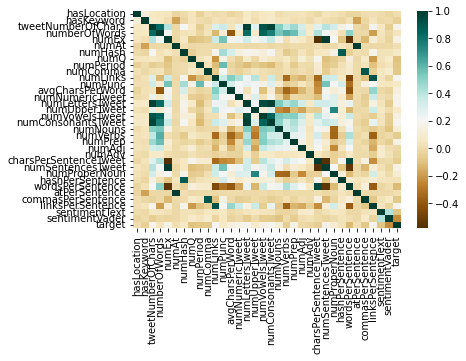

In [22]:
# Make heatmap to visualize
import seaborn as sns
sns.heatmap(corr, cmap='BrBG', yticklabels=True, xticklabels=True)

In [23]:
data_for_model = data
# data_for_model = data[top10]
# data_for_model['target'] = train['target']


data_for_model

,hasLocation,hasKeyword,tweetNumberOfChars,numberOfWords,numEx,numAt,numHash,numQ,numPeriod,numComma,...,numSentencesTweet,numProperNoun,hashPerSentence,wordsPerSentence,atPerSentence,commasPerSentence,linksPerSentence,sentimentText,sentimentVader,target
0,0,0,69,13,0,0,1,0,0,0,...,1,4,1.0,13.000000,0.0,0.0,0.00,0.000000,0.2732,1
1,0,0,38,7,1,0,0,0,0,0,...,2,5,0.0,3.500000,0.0,0.0,0.00,0.100000,-0.3400,1
2,0,0,133,22,1,0,0,0,0,0,...,2,1,0.0,11.000000,0.0,0.0,0.00,-0.018750,-0.2960,1
3,0,0,65,8,0,1,1,0,0,0,...,1,1,1.0,8.000000,1.0,0.0,0.00,0.000000,0.0000,1
4,0,0,88,16,0,0,2,0,0,0,...,1,2,2.0,16.000000,0.0,0.0,0.00,0.000000,0.0000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7608,0,0,83,11,1,0,0,0,0,0,...,2,0,0.0,5.500000,0.0,0.0,0.50,0.000000,-0.4939,1
7609,0,0,125,20,2,0,0,2,0,0,...,3,3,0.0,6.666667,0.0,0.0,0.00,0.150000,-0.5849,1
7610,0,0,65,8,3,0,0,0,1,0,...,4,6,0.0,2.000000,0.0,0.0,0.25,0.000000,0.0000,1
7611,0,0,137,19,2,0,0,0,0,0,...,3,4,0.0,6.333333,0.0,0.0,0.00,-0.260417,-0.7845,1


In [33]:
# split to train and test data
trainData = data_for_model.sample(frac = 0.8, random_state = 25)
testData = data_for_model.drop(trainData.index)

stopIndex = data_for_model.shape[1] - 1

trainArray = trainData.values
trainX = trainArray[:,0:stopIndex]
trainY = trainArray[:,stopIndex]

testArray = testData.values
testX = testArray[:,0:stopIndex]
testY = testArray[:,stopIndex]

train accuracy: 0.9975369458128078 
 test accuracy: 0.7288246881155613
Classification Report
              precision    recall  f1-score   support

         0.0       0.72      0.85      0.78       875
         1.0       0.74      0.56      0.64       648

    accuracy                           0.73      1523
   macro avg       0.73      0.71      0.71      1523
weighted avg       0.73      0.73      0.72      1523


Confusion Matrix


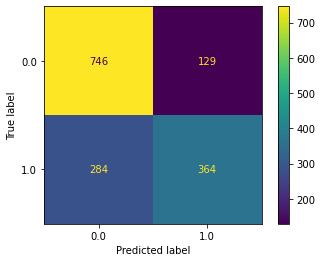

In [34]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Get features and labels
X = data_for_model.drop(['target'], axis=1)
y = data_for_model['target']

# Create prelim RFC
model = RandomForestClassifier()
model.fit(trainX, trainY)
pred = model.predict(testX)

# Print train and test accuracy
print("train accuracy:",model.score(trainX, trainY),"\n","test accuracy:",model.score(testX,testY))

# Classification report and confusion matrix
print("Classification Report")
print(classification_report(testY, pred))
print("\nConfusion Matrix")
ConfusionMatrixDisplay.from_estimator(model, testX, testY)

In [35]:
# Show cross-validation for basic model
cv_scores = cross_val_score(model, X, y, cv=10, scoring='accuracy')
print(cv_scores)

print(cv_scores.mean())

[0.68897638 0.71784777 0.64698163 0.66622865 0.6977661  0.66754271
 0.69382392 0.64914586 0.75952694 0.68988173]
0.6877721674409621


In [37]:
# Randomly fit different hyperparameters to find optimal

# number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# number of features at every split
max_features = ['auto', 'sqrt']

# max depth
max_depth = [int(x) for x in np.linspace(100, 500, num = 11)]
max_depth.append(None)
# create random grid
random_grid = {
 'n_estimators': n_estimators,
 'max_features': max_features,
 'max_depth': max_depth
 }
# Random search of parameters
model_random = RandomizedSearchCV(estimator = model, param_distributions = random_grid, n_iter = 50, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the model
model_random.fit(trainX, trainY)
# print results
print(model_random.best_params_)


Fitting 3 folds for each of 50 candidates, totalling 150 fits
{'n_estimators': 200, 'max_features': 'sqrt', 'max_depth': None}


train accuracy: 0.9975369458128078 
 test accuracy: 0.7393302692055155
Classification Report
              precision    recall  f1-score   support

         0.0       0.73      0.86      0.79       875
         1.0       0.75      0.58      0.65       648

    accuracy                           0.74      1523
   macro avg       0.74      0.72      0.72      1523
weighted avg       0.74      0.74      0.73      1523


Confusion Matrix


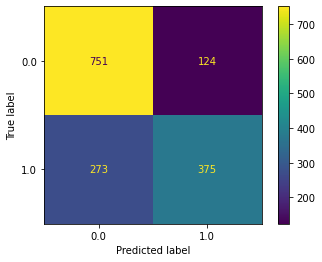

In [38]:
# New model with better parameters
model = RandomForestClassifier(n_estimators=200, max_depth=None, max_features='sqrt')
model.fit(trainX, trainY)
pred = model.predict(testX)

# Print train and test accuracy
print("train accuracy:",model.score(trainX, trainY),"\n","test accuracy:",model.score(testX,testY))

# Classification report and confusion matrix
print("Classification Report")
print(classification_report(testY, pred))
print("\nConfusion Matrix")
ConfusionMatrixDisplay.from_estimator(model, testX, testY)

In [39]:
# Show cross-validation for improved model
cv_scores = cross_val_score(model, X, y, cv=10, scoring='accuracy')
print(cv_scores)

print(cv_scores.mean())

[0.7007874  0.72440945 0.6496063  0.66885677 0.6911958  0.67542707
 0.70170828 0.65571616 0.76346912 0.68856767]
0.6919744016886195


## PREPPING KAGGLE SUBMISSION

In [40]:
# import the kaggle unlabeled data, feature extract, and predict
test = pd.read_csv('test.csv')

# clean tweets    
def clean_non_printable(text):
    cleaned = ''.join([word for word in text if word.isprintable()])
    return cleaned
def clean_char_references(text):
    cleaned = re.sub(r'&[a-zA-Z]+;?', '', text)
    return cleaned
test['text'] = test['text'].apply(clean_non_printable)
test['text'] = test['text'].apply(clean_char_references)
cleanedTweets = []
for index in range(len(test)):
    tweet = test['text'][index]
    cleaned = re.sub(r'[^\w\s]', '', str(tweet).lower().strip())
    cleanedTweets.append(cleaned)
test['cleanedTweets'] = cleanedTweets
# textblob sentiment
test["sentimentText"] = test['cleanedTweets'].apply(lambda x: 
                                                      TextBlob(x).sentiment.polarity)
# vader sentiment
test["sentimentVader"] = test['cleanedTweets'].apply(lambda x: 
                                                       analyser.polarity_scores(x)['compound'])
charsToCheck = {'!', '@', '#', '?', '.', ',', 'http'}
vowels = {'a', 'e', 'i', 'o', 'u', 'A', 'E', 'I', 'O', 'U'}
nouns = {'NN', 'NNS', 'NNP', 'NNPS'}
verbs = {'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ'}
adj = {'JJ', 'JJR', 'JJS'}
adv = {'RR', 'RBR', 'RBS'}

hasLocation = []
hasKeyword = []
tweetNumberOfChars = []
specialCharacters = []
numberOfWords = []
avgCharsPerWord = []
numNumericTweet = []
numLettersTweet = []
numUpperTweet = []
numVowelsTweet = []
numConsonantsTweet = []
numNouns = []
numVerbs = []
numPrep = []
numAdj = []
numAdv = []
charsPerSentenceTweet = []
numSentencesTweet = []
numProperNoun = []


for index in range(len(test)):
    ##### location
    location = 0
    if pd.isnull(test['location'][index]) == False:
            location = 1
            
    ##### keyword
    keyword = 0
    if pd.isnull(test['keyword'][index]) == False:
            keyword = 1
    
    ###### tweet
    text = test['text'][index]
    # number of characters in tweets
    numCharsTweet = len(text)
    
    # average number of characters in sentence
    sentences = text.split('.')
    charsPerSentence = []
    for sentence in sentences:
        numCharsSentence = len(sentence)
        charsPerSentence.append(numCharsSentence)
    avgCharsPerSentence = np.mean(charsPerSentence)
    
    # number of specific special characters in tweet
    specialChars = []
    for specialChar in charsToCheck:
        numSpecialChar = text.count(specialChar)
        specialChars.append(numSpecialChar)
    
    # average characters per word
    words = text.split()
    lenWords = []
    numNumeric = 0
    numLetters = 0
    numUpper = 0
    numVowels = 0
    numConsonants = 0
    
    nounNum = 0
    verbNum = 0
    prepNum = 0
    adjNum = 0
    advNum = 0
    properNounNum = 0
    
    ans = nltk.pos_tag(words)
    for pair in ans:
        wordType = pair[1]
        if (wordType == 'NNP') or (wordType == 'NNPS'):
            properNounNum += 1
        elif wordType in nouns:
            nounNum += 1
        elif wordType in verbs:
            verbNum += 1
        elif wordType == 'IN':
            prepNum += 1
        elif wordType in adj:
            adjNum += 1
        elif wordType in adv:
            advNum += 1
    
    for word in words:
        wordLength = len(word)
        lenWords.append(wordLength)
        
        # number of letters/numbers, uppercase, vowels, consonants
        for char in word:
            if char.isnumeric():
                numNumeric += 1
            if char.isalpha():
                numLetters += 1
                if char.isupper():
                    numUpper += 1
                if char in vowels:
                    numVowels += 1
                else:
                    numConsonants += 1
        
    wordLengthAvg = np.mean(lenWords)
    
    # tweets with 1 word
    if math.isnan(wordLengthAvg):
        wordLengthAvg = 1
    
    # number of words and sentences
    numWords = len(words)
    numSentences = len(sentences)
    
    hasLocation.append(location)
    hasKeyword.append(keyword)
    tweetNumberOfChars.append(numCharsTweet)
    specialCharacters.append(specialChars)
    numberOfWords.append(numWords)
    avgCharsPerWord.append(wordLengthAvg)
    numNumericTweet.append(numNumeric)
    numLettersTweet.append(numLetters)
    numUpperTweet.append(numUpper)
    numVowelsTweet.append(numVowels)
    numConsonantsTweet.append(numConsonants)
    numNouns.append(nounNum)
    numVerbs.append(verbNum)
    numPrep.append(prepNum)
    numAdj.append(adjNum)
    numAdv.append(advNum)
    charsPerSentenceTweet.append(avgCharsPerSentence)
    numSentencesTweet.append(numSentences)
    numProperNoun.append(properNounNum)

    
# specials
numEx = []
numAt = []
numHash = []
numQ = []
numPeriod = []
numComma = []
numLinks = []
numPunc = []

for tweetCharacters in specialCharacters:
    totalPunc = 0
    for index in range(len(charsToCheck)):
        value = tweetCharacters[index]
        totalPunc += value
        if index == 0:
            numEx.append(value)
        elif index == 1:
            numAt.append(value)
        elif index == 2:
            numHash.append(value)
        elif index == 3:
            numQ.append(value)
        elif index == 4:
            numPeriod.append(value)
        elif index == 5:
            numComma.append(value)
        elif index == 6:
            numLinks.append(value)
    numPunc.append(totalPunc)
    
# create new dataframe
colNames = ['hasLocation', 'hasKeyword', 'tweetNumberOfChars', 'numberOfWords', 'numEx', 
            'numAt', 'numHash', 'numQ', 'numPeriod', 'numComma', 'numLinks', 'numPunc',
            'avgCharsPerWord', 'numNumericTweet', 'numLettersTweet', 'numUpperTweet',
            'numVowelsTweet', 'numConsonantsTweet', 'numNouns', 'numVerbs', 'numPrep', 
            'numAdj', 'numAdv', 'charsPerSentenceTweet', 'numSentencesTweet', 'numProperNoun']
colValues = [hasLocation, hasKeyword, tweetNumberOfChars, numberOfWords, numEx, numAt, 
             numHash,numQ, numPeriod, numComma, numLinks, numPunc, avgCharsPerWord, 
             numNumericTweet, numLettersTweet, numUpperTweet, numVowelsTweet, 
             numConsonantsTweet, numNouns, numVerbs, numPrep, numAdj, numAdv, 
             charsPerSentenceTweet, numSentencesTweet, numProperNoun]

# create new dataframe
data = pd.DataFrame()
for index in range(len(colNames)):
    colName = colNames[index]
    colVals = colValues[index]
    data[colName] = colVals


    
hashPerSentence = []
wordsPerSentence = []
atPerSentence = []
commasPerSentence = []
linksPerSentence = []

for index in range(len(data)):
    numSentences = data['numSentencesTweet'][index]
    numHash = data['numHash'][index]
    numWords = data['numberOfWords'][index]
    numAt = data['numAt'][index]
    numComma = data['numComma'][index]
    numLinks = data['numLinks'][index]
    
    hashPer = numHash / numSentences
    wordsPer = numWords / numSentences
    atPer = numAt / numSentences
    commasPer = numComma / numSentences
    linksPer = numLinks / numSentences
    
    hashPerSentence.append(hashPer)
    wordsPerSentence.append(wordsPer)
    atPerSentence.append(atPer)
    commasPerSentence.append(commasPer)
    linksPerSentence.append(linksPer)
    
    
data['hashPerSentence'] = hashPerSentence
data['wordsPerSentence'] = wordsPerSentence
data['atPerSentence'] = atPerSentence
data['commasPerSentence'] = commasPerSentence
data['linksPerSentence'] = linksPerSentence

# data['ttr'] = ttr
data['sentimentText'] = test['sentimentText']
data['sentimentVader'] = test['sentimentVader']


# save some stuff to csv for quick reaccess
# data.to_csv('features.csv')
# pd.DataFrame(ttr).to_csv('ttr.csv')

data

,hasLocation,hasKeyword,tweetNumberOfChars,numberOfWords,numEx,numAt,numHash,numQ,numPeriod,numComma,...,charsPerSentenceTweet,numSentencesTweet,numProperNoun,hashPerSentence,wordsPerSentence,atPerSentence,commasPerSentence,linksPerSentence,sentimentText,sentimentVader
0,0,0,34,6,0,0,0,0,0,0,...,34.00,1,0,0.0,6.00,0.0,0.0,0.0,-1.00,-0.7003
1,0,0,64,9,1,1,1,0,0,0,...,31.50,2,2,0.5,4.50,0.5,0.0,0.0,0.25,0.4404
2,0,0,96,19,0,2,0,0,0,0,...,96.00,1,0,0.0,19.00,2.0,0.0,0.0,0.00,-0.6159
3,0,0,40,4,1,0,2,0,0,0,...,19.50,2,1,1.0,2.00,0.0,0.0,0.0,0.00,0.0000
4,0,0,45,8,0,0,0,0,0,0,...,45.00,1,4,0.0,8.00,0.0,0.0,0.0,0.00,-0.5423
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3258,0,0,54,8,0,0,0,0,0,0,...,54.00,1,8,0.0,8.00,0.0,0.0,0.0,0.00,0.6808
3259,0,0,134,23,3,0,0,0,0,0,...,32.75,4,2,0.0,5.75,0.0,0.0,0.0,-0.20,-0.1531
3260,0,0,55,6,1,0,0,0,0,0,...,27.00,2,2,0.0,3.00,0.0,0.0,0.5,-0.20,0.0000
3261,0,0,65,7,1,0,0,0,0,0,...,32.00,2,5,0.0,3.50,0.0,0.0,0.5,0.60,0.0000


In [41]:
# Create predictions on test set based on model
prediction = pd.Series(model.predict(data))


C:\Users\jexia\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


In [44]:
prediction = prediction.apply(np.int64)

submission = {'id': test['id'], 
             'target': prediction}

submission = pd.concat(submission, axis=1)
submission

submission.to_csv('submission.csv', index = False)